# TES Simulatior Example Notebook

'tes_simulator package' </br>
https://github.com/tomma90/tes_simulator <br>

'Tommaso's phD thesis' <br>
https://ora.ox.ac.uk/objects/uuid:a8124ed3-683f-49ac-9ad7-7a366292490d


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tes_simulator as tessim
import pandas as pd
import os
import sys
import datetime

## Output of tes_simulator

* We will get TES current TOD or TES tempearture TOD by this package. <br>
* We can set multiple TES design parameters. <br>
* Also we can give parameters that change the TES behavior e.g. bath temperature fluctuation, optical loading variation, etc. <br>

# Resistance vs Temperature 
R vs T is calculated by an "arctan model" <br>
LiteBIRD like default TES model: <br>
$T_{\mathrm{bath}}$ = 100 [mK] <br>
$T_{c}$ = 171 [mK] (minimize phonon noise: $T_{c} = T_{\mathrm{bath}} \times 1.71$)<br>
$R_{n}$ = 1 [$\Omega$] <br> 
log sensitivity $\alpha_{\mathrm{TES}}$ = dlogR/dlogT = 100 at R~0.5$\Omega$. <br> 
$R_{\mathrm{TES}}$ is TES resister with arctan model given temperature T <br>
Definitions are following: 

$
A =  \alpha R_{n} \frac{\pi}{2} \frac{(T_{c}^2+1) }{Tc}
$

$
R_{\mathrm{TES}} = \frac{R_{n}}{\pi} \arctan\{(T_{\mathrm{TES}}-T_{c})A + \frac{\pi}{2}\}
$

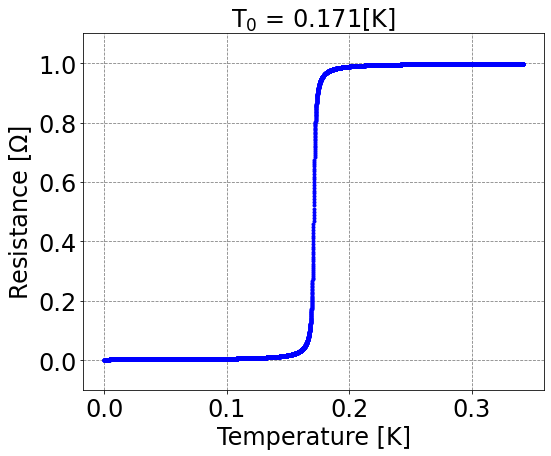

In [6]:
tesDC = tessim.tes_dc_model()
plt.figure(figsize=(8,6))
plt.ylabel("Resistance [$\Omega$]")
plt.xlabel("Temperature [K]")
T_TES = np.linspace(0, 0.171*2, 10001)
R_TES = tessim.resistance_vs_temperature_dc(T_TES)
plt.title("T$_{0}$ = " + str(tesDC.tes_transition_temperature) + "[K]")
plt.plot(T_TES,R_TES,".b")
plt.ylim(-0.1,1.1)
plt.show()

# Log sensitivity vs Resistance

$
\alpha = \frac{d \log{R}}{d \log{T}}
$

In [7]:
T_TES = np.linspace(1e-4, 0.171*2, 10001)
R_TES = tessim.resistance_vs_temperature_dc(T_TES)
logR = np.log(R_TES)
logT = np.log(T_TES)
alpha = np.diff(logR)/np.diff(logT)

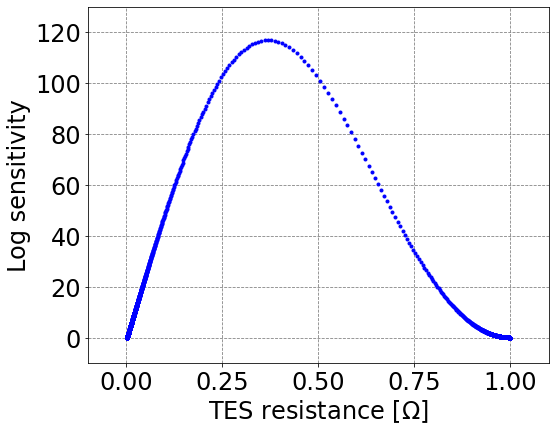

In [8]:
plt.figure(figsize=(8,6))
plt.ylabel("Log sensitivity")
plt.xlabel("TES resistance [$\Omega$]")
plt.plot(R_TES[:-1],alpha,".b")
plt.xlim(-0.1,1.1)
plt.ylim(-10,130)
plt.show()

# Differential equation

## Input parameters

bias current: I$_{\mathrm{bias}}$ = 33 [$\mu$A] <br>
shunt resistor: R$_{s}$ = 0.02 [$\Omega$] <br>
bias voltage: V$_{\mathrm{bias}}$ <br>

$
V_{\mathrm{bias}} = I_{\mathrm{bias}} \frac{R_{\mathrm{TES}} R_{s}}{R_{\mathrm{TES}} + R_{s}}
$

Optical loading power: $P_{\mathrm{opt}}$ = 0.5 [pW] <br>
Saturation power: $P_{\mathrm{sat}} = 2.5 \times P_{\mathrm{opt}}$ [W] <br>
n = 4 for phonon case <br>


$G$: Thermal conductivity of the leg <br>

$
G = P_{\mathrm{sat}} \frac{nT_{c}^{n-1}}{T_{c}^{n} - T_{\mathrm{bath}}^{n}}
$

$P_{\mathrm{bath}}$: Power out of the leg from focal plane<br>

$
P_{\mathrm{bath}} = \frac{G}{nT_{\mathrm{TES}}^{n-1}}(T_{\mathrm{TES}}^{n}-T_{\mathrm{bath}}^{n})
$

$P_{\mathrm{ele}}$: Electrical power <br>

$
P_{\mathrm{ele}} = V_{\mathrm{bias}}^2 / R_{\mathrm{TES}}
$

## Differential equation formula 

SQUID inductor: L = 65.e-6 [H] <br>
TES heat capacity: C = $\tau_0 \times$G <br>
TES thermal time constant: $\tau_0$ = 33 [ms] <br>

$
\frac{dI_{\mathrm{TES}}}{dt} = (V - I_{\mathrm{TES}} R_{s} - I_{\mathrm{TES}} R_{\mathrm{TES}}) / L
$

$
\frac{dT_{\mathrm{TES}}}{dt} = (−P_{\mathrm{bath}}+P_{\mathrm{ele}}+P_{\mathrm{opt}})/C
$

# TES simulation

We want to calculate $I_{TES}$ and $T_{TES}$ <br>
Runge - Kutta method is used to solve differential equation, with step size $h$ <br>

$
y_{0} = y(x_{0}), \ {dy\over{dx}} = f(x,y)
$

For each step $n$, 

$
x_{n+1} = x_{n} + h, \ y_{n+1} = y_{n} + \frac{h}{6} (k_1 + 2k_2 + 2k_3 + k_4) + O(h^5)
$

$
k_1 = f(x_n,y_n), \ k_2 = f(x_n + {h\over2},y_n+k_1{h\over2}), \ k_3 = f(x_n + {h\over2},y_n+k_2{h\over2}), \ k_4 = f(x_n + h,y_n+k_3 h) 
$

Applying to $I_{TES}$ and $T_{TES}$,

$
I_{\mathrm{TES}}(0) = I_{\mathrm{bias}}, \ \frac{dI_{TES}}{dt} = f(t,I_{\mathrm{TES}})
$

$
T_{\mathrm{TES}}(0) = T_{c}, \ \frac{dT_{TES}}{dt} = f(t,T_{\mathrm{TES}})
$

## DC model with Constant input parameters

In [9]:
tesDC = tessim.tes_dc_model()
fs = 1e4 #[Hz]
time_range = [0., 0.05]
time_array = np.arange(time_range[0], time_range[1], 1/fs)
bias_current_array = np.ones_like(time_array) * tesDC.biasing_current
loading_power_array = np.ones_like(time_array) * tesDC.optical_loading_power
bath_temperature_array = np.ones_like(time_array) * tesDC.temperature_focal_plane
tes_current = np.zeros_like(time_array)
tes_temperature = np.zeros_like(time_array)
tes_current_DC, tes_temperature_DC = tessim.TesDcRungeKuttaSolver(time_array, bias_current_array, loading_power_array, bath_temperature_array, tes_current, tes_temperature, tesDC)

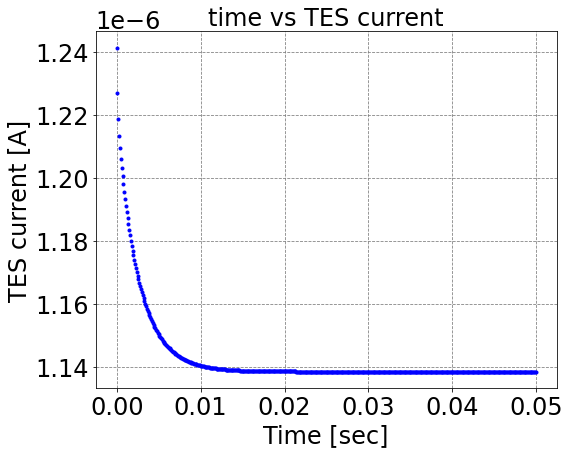

In [10]:
plt.figure(figsize=(8,6))
plt.title('time vs TES current')
plt.xlabel('Time [sec]')
plt.ylabel('TES current [A]')
plt.plot(time_array, tes_current_DC, 'b.')
plt.show()

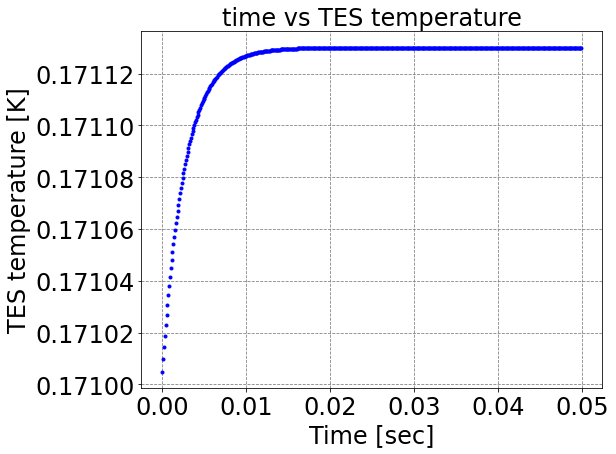

In [11]:
plt.figure(figsize=(8,6))
plt.title('time vs TES temperature')
plt.xlabel('Time [sec]')
plt.ylabel('TES temperature [K]')
plt.plot(time_array, tes_temperature_DC, 'b.')
plt.show()

## AC model with Constant input parameters

In [8]:
tesAC = tessim.tes_ac_model()
fs_ac = 20e6

In [ ]:
time_range_ac = [0., 0.05]
time_array_ac = np.arange(time_range_ac[0], time_range_ac[1], 1/fs_ac)
bias_current_array_ac = np.ones_like(time_array) * tesAC.biasing_current_amplitude
loading_power_array_ac = np.ones_like(time_array) * tesAC.optical_loading_power
bath_temperature_array_ac = np.ones_like(time_array) * tesAC.temperature_focal_plane
tes_current_ac = np.zeros_like(time_array)
tes_temperature_ac = np.zeros_like(time_array)
tes_current_ac, tes_temperature_ac = tessim.TesAcRungeKuttaSolver(time_array_ac, bias_current_array_ac, loading_power_array_ac, bath_temperature_array_ac, tes_current_ac, tes_temperature_ac, tesAC)

In [ ]:
plt.figure(figsize=(8,6))
plt.title('time vs TES current')
plt.xlabel('Time [sec]')
plt.ylabel('TES current [A]')
plt.plot(time_array,tes_current,'b-')
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
plt.title('time vs TES current')
plt.xlabel('Time [sec]')
plt.ylabel('TES current [A]')
plt.plot(time_array,tes_current,'b-')
plt.xlim(0,1e-5)
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
plt.title('time vs TES temperature')
plt.xlabel('Time [sec]')
plt.ylabel('TES temperature [K]')
plt.plot(time_array, tes_temperature, 'b.')
plt.show()

# TOD modling with tes_simulator

TOD implementing TES behavior:

$
d = [S_{I}(s + n_{\gamma}) + n_{J} + n_{G} + n_{X} + n_{R}]S_{V} + d_{\mathrm{offset}}
$

$d$ : TOD [V]  <br>
$S_{I}$ [A/W]: TES Current responsivity  <br>
$S_{V}$ [V/A]: SQUID Voltage responsivity  <br>
$s$ [W]: Incoming optical loading <br>
$n_{\gamma}$ [W]: Photon noise contribution <br>
$n_{J,G,R}$ [A]: Johnson noise and phonon noise of the bolometer, and the read-out noise  <br>
$n_{X}$[A], $d_{\mathrm{offset}}$ [V]: Extra noise and voltage offset  <br>

$
S_{I} = \frac{1}{V_{\mathrm{bias}}} \frac{\mathcal{L}}{\mathcal{L}+1} \frac{1}{1+i\omega t}\ [A/W],
$

where <br>
$
\mathcal{L} = \frac{\alpha P_{\mathrm{ele}}}{GT_{\mathrm{TES}}}
$


Notice that in the limit of slow signal variations with respect to the time constant τ (ω → 0),
we can drop the 1/(1 + ωτ ) term

$
S_{V} = M \frac{\partial V}{\partial \Phi} \ [V/A]
$

## Loop gain

$
\mathcal{L} = \frac{\alpha P_{\mathrm{ele}}}{GT_{\mathrm{TES}}},
$

where <br>
$
G = P_{sat} \frac{nT_{c}^{n-1}}{T_{c}^{n} - T_{bath}^{n}}, \ P_{\mathrm{ele}} = V_{\mathrm{bias}}^2 / R_{\mathrm{TES}}
$

In [12]:
G = tesDC.tes_leg_thermal_conductivity
a = tesDC.tes_log_sensitivity_alpha

Ttes = tes_temperature_DC
Rtes = tessim.resistance_vs_temperature_dc(Ttes)
Vbias = tesDC.biasing_current * Rtes * tesDC.shunt_resistor / (Rtes + tesDC.shunt_resistor)
Pele = Vbias * Vbias / Rtes

tes_loop_gain_DC = a * Pele / G / Ttes 

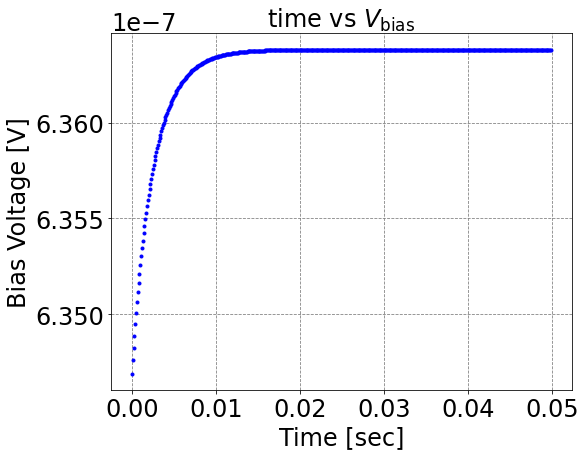

In [13]:
plt.figure(figsize=(8,6))
plt.title('time vs $V_{\mathrm{bias}}$')
plt.xlabel('Time [sec]')
plt.ylabel('Bias Voltage [V]')
plt.plot(time_array, Vbias, 'b.')
plt.show()

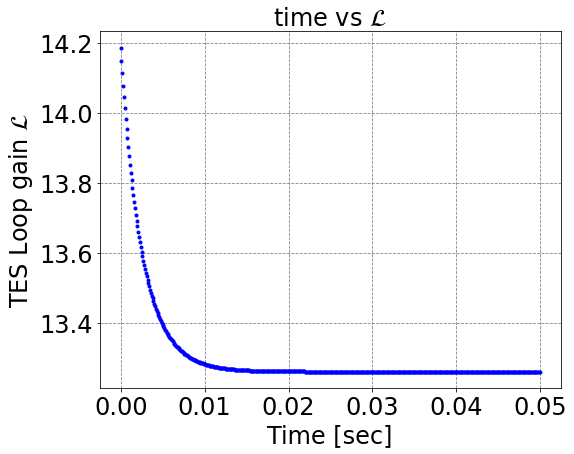

In [14]:
plt.figure(figsize=(8,6))
plt.title(r'time vs $\mathcal{L}$')
plt.xlabel('Time [sec]')
plt.ylabel(r'TES Loop gain $\mathcal{L}$')
plt.plot(time_array, tes_loop_gain_DC, 'b.')
plt.show()

## Time constant

$
\tau = \frac{C}{G} \frac{1}{1+\mathcal{L}}
$

In [15]:
C = tesDC.tes_heat_capacity
tes_tau_DC = C / G / (1+tes_loop_gain_DC)

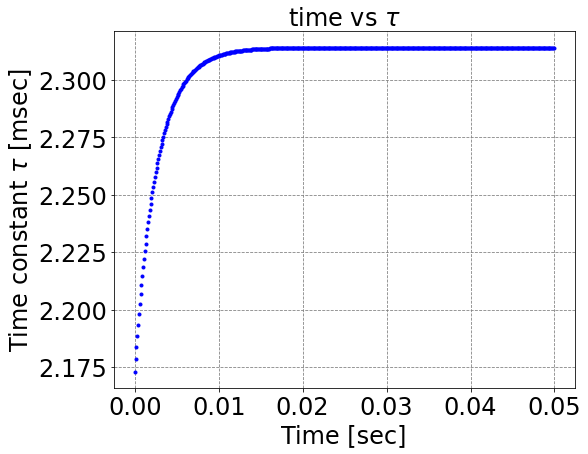

In [16]:
plt.figure(figsize=(8,6))
plt.title(r'time vs $\tau$')
plt.xlabel('Time [sec]')
plt.ylabel(r'Time constant $\tau$ [msec]')
plt.plot(time_array, tes_tau_DC*1e3, 'b.')
plt.show()

## TES current responsivity

$
S_{I} = \frac{1}{V_{\mathrm{bias}}} \frac{\mathcal{L}}{\mathcal{L}+1} \frac{1}{1+i\omega t}\ [A/W],
$

In [17]:
S_I_DC = (1 / Vbias) * (tes_loop_gain_DC / (1+tes_loop_gain_DC))

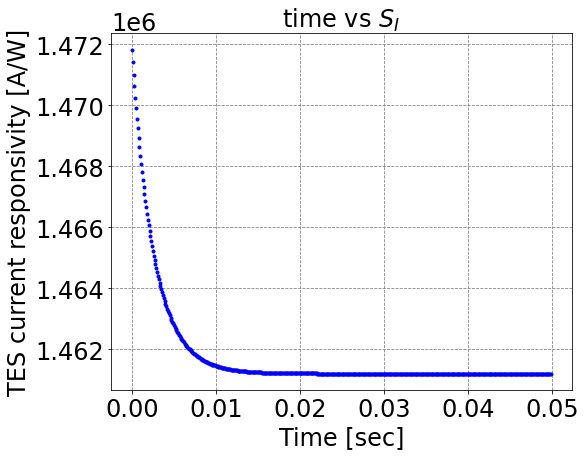

In [18]:
plt.figure(figsize=(8,6))
plt.title('time vs $S_{I}$')
plt.xlabel('Time [sec]')
plt.ylabel('TES current responsivity [A/W]')
plt.plot(time_array, S_I_DC, 'b.')
plt.show()

# TES non-linearity 

## Fractional variation

In [16]:
T_TES = np.linspace(1e-4, 0.171*2, 10001)
R_TES = tessim.resistance_vs_temperature_dc(T_TES)
logR = np.log(R_TES)
logT = np.log(T_TES)
alpha = np.diff(logR)/np.diff(logT)
#for i in range(len(R_TES)): print(R_TES[i])

In [ ]:
def tes_parameters(tes_model, tes_log_sensitivity_alpha=0.7):
    
    fs = 1e4 #[Hz]
    time_range = [0., 0.05]
    time_array = np.arange(time_range[0], time_range[1], 1/fs)
    bias_current_array = np.ones_like(time_array) * tesDC.biasing_current
    loading_power_array = np.ones_like(time_array) * tesDC.optical_loading_power
    bath_temperature_array = np.ones_like(time_array) * tesDC.temperature_focal_plane
    tes_current = np.zeros_like(time_array)
    tes_temperature = np.zeros_like(time_array)
    tes_current, tes_temperature = tessim.TesDcRungeKuttaSolver(time_array, bias_current_array, loading_power_array, bath_temperature_array, tes_current, tes_temperature, tes_model)
    G = tesDC.tes_leg_thermal_conductivity
    a = tesDC.tes_log_sensitivity_alpha
    Ttes = tes_temperature_DC
    Rtes = tessim.resistance_vs_temperature_dc(Ttes)
    Vbias = tesDC.biasing_current * Rtes * tesDC.shunt_resistor / (Rtes + tesDC.shunt_resistor)
    Pele = Vbias * Vbias / Rtes
    C = tesDC.tes_heat_capacity
    
    tes_loop_gain_0 = a * Pele / G / Ttes 
    tes_tau_0 = C / G / (1+tes_loop_gain_DC)
    S_I_0 = (1 / Vbias) * (tes_loop_gain_DC / (1+tes_loop_gain_DC))

In [ ]:
tesDC = tessim.tes_dc_model()
fs = 1e4 #[Hz]
time_range = [0., 0.05]
time_array = np.arange(time_range[0], time_range[1], 1/fs)
bias_current_array = np.ones_like(time_array) * tesDC.biasing_current
loading_power_array = np.ones_like(time_array) * tesDC.optical_loading_power
bath_temperature_array = np.ones_like(time_array) * tesDC.temperature_focal_plane
tes_current = np.zeros_like(time_array)
tes_temperature = np.zeros_like(time_array)
tes_current_DC, tes_temperature_DC = tessim.TesDcRungeKuttaSolver(time_array, bias_current_array, loading_power_array, bath_temperature_array, tes_current, tes_temperature, tesDC)

G = tesDC.tes_leg_thermal_conductivity
a = tesDC.tes_log_sensitivity_alpha
Ttes = tes_temperature_DC
Rtes = tessim.resistance_vs_temperature_dc(Ttes)
Vbias = tesDC.biasing_current * Rtes * tesDC.shunt_resistor / (Rtes + tesDC.shunt_resistor)
Pele = Vbias * Vbias / Rtes
C = tesDC.tes_heat_capacity

tes_loop_gain_0 = a * Pele / G / Ttes 
tes_tau_0 = C / G / (1+tes_loop_gain_DC)
S_I_0 = (1 / Vbias) * (tes_loop_gain_DC / (1+tes_loop_gain_DC))

### $P_{\mathrm{opt}}$ variation

## $T_{bath}$ fluctuation

### 1/f generation

$
\sigma = 30 [\mu K], \  f_{\mathrm{knee}}=1 [\mathrm{Hz}], \ \alpha = 1.8
$

$
P(T_{\mathrm{bath}}) = \sigma^2 (\frac{f_{\mathrm{knee}}}{f})^\alpha
$

In [19]:
import math
fknee = 1.
alpha = 1.8
fs = 1000 #[Hz]
time_range = [0., 60*60*24]
time_array = np.arange(time_range[0], time_range[1], 1/fs)
N = pow(2, math.ceil(math.log(len(time_array), 2)))
noise = np.random.normal(0, 30e-6, N) ** 2
fft = np.fft.fft(noise, n=N)
freqs = np.fft.fftfreq(N, d=1/(2*fs))
model = freqs
model[freqs != 0] = pow(abs(fknee / freqs[freqs != 0]), alpha)
model[freqs == 0] = 0
fft = fft * model 
ifft = np.fft.ifft(fft)
dTbath = np.real(ifft[:len(time_array)]) 
one_over_f_fft = np.abs(fft[1:int(N/2)])
one_over_f_freq = np.fft.fftfreq(N,1/fs)[1:int(N/2)]

In [20]:
#import matplotlib.mlab as mlab
#dTbath_fft = np.sqrt(mlab.psd(dTbath, Fs=fs, NFFT=len(dTbath))[0])
#dTbath_freq = mlab.psd(dTbath, Fs=fs, NFFT=len(dTbath))[1]

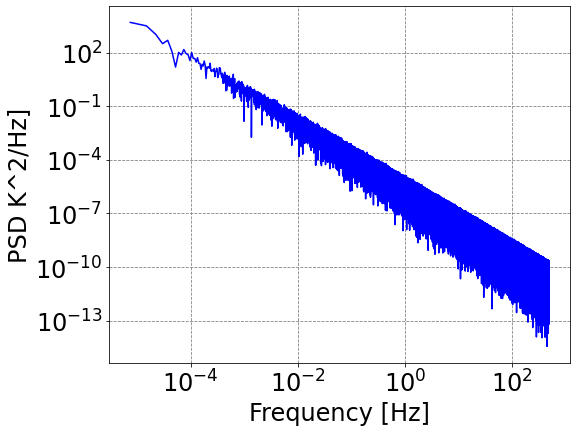

In [21]:
plt.figure(figsize=(8,6))
plt.plot(one_over_f_freq,one_over_f_fft,"b-")
plt.xlabel("Frequency [Hz]")
plt.ylabel(r"PSD K^2/Hz]")
plt.xscale("log")
plt.yscale("log")
plt.show()

In [22]:
bath_temperature_array = np.ones_like(time_array) * tesDC.temperature_focal_plane * dTbath

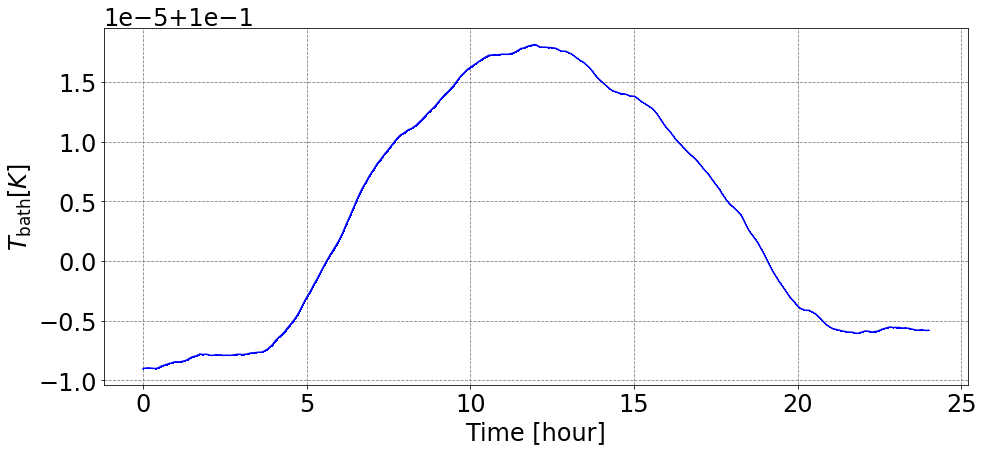

In [21]:
plt.figure(figsize=(15,6))
plt.plot(time_array/60/60,bath_temperature_array+0.1,".-b",markersize=0.01)
plt.xlabel("Time [hour]")
plt.ylabel("$T_{\mathrm{bath}} [K]$")
#plt.ylim(-3e-6,3e-6)
plt.show()

### tes_simulator

In [22]:
import math
fknee = 1.
alpha = 1.8
fs = 10000 #[Hz]
time_range = [0., 60*60*24]
time_array = np.arange(time_range[0], time_range[1], 1/fs)
N = pow(2, math.ceil(math.log(len(time_array), 2)))
noise = np.random.normal(0, 30e-6, N) ** 2
fft = np.fft.fft(noise, n=N)
freqs = np.fft.fftfreq(N, d=1/(2*fs))
model = freqs
model[freqs != 0] = pow(abs(fknee / freqs[freqs != 0]), alpha)
model[freqs == 0] = 0
fft = fft * model 
ifft = np.fft.ifft(fft)
dTbath = np.real(ifft[:len(time_array)]) 
one_over_f_fft = np.abs(fft[1:int(N/2)])
one_over_f_freq = np.fft.fftfreq(N,1/fs)[1:int(N/2)]

In [23]:
tesDC = tessim.tes_dc_model()
bath_temperature_array = np.ones_like(time_array) * tesDC.temperature_focal_plane
bath_temperature_array += dTbath

In [1]:
plt.figure(figsize=(15,6))
plt.plot(time_array,bath_temperature_array,".-b",markersize=1)
plt.xlabel("Time [hour]")
plt.ylabel("$T_{\mathrm{bath}} [K]$")
plt.show()

NameError: name 'plt' is not defined

In [ ]:
bias_current_array = np.ones_like(time_array) * tesDC.biasing_current
loading_power_array = np.ones_like(time_array) * tesDC.optical_loading_power
tes_current = np.zeros_like(time_array)
tes_temperature = np.zeros_like(time_array)

bath_temperature_array = np.ones_like(time_array) * tesDC.temperature_focal_plane
bath_temperature_array += dTbath

tes_current, tes_temperature = tessim.TesDcRungeKuttaSolver(time_array, bias_current_array, loading_power_array, bath_temperature_array, tes_current, tes_temperature, tesDC)

bath_temperature_array = np.ones_like(time_array) * tesDC.temperature_focal_plane
tes_current_0 = np.zeros_like(time_array)
tes_temperature_0 = np.zeros_like(time_array)
tes_current_0, tes_temperature_0 = tessim.TesDcRungeKuttaSolver(time_array, bias_current_array, loading_power_array, bath_temperature_array, tes_current_0, tes_temperature_0, tesDC)

In [ ]:
plt.figure(figsize=(8,6))
plt.xlabel('Time [sec]')
plt.ylabel('TES current [A]')
idx = np.where(time_array>1)
plt.plot(time_array[idx], tes_current[idx], 'b.')
plt.gca().yaxis.offsetText.set_fontsize(18)
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
plt.xlabel('Time [sec]')
plt.ylabel('TES temperature [K]')
idx = np.where(time_array>1)
plt.plot(time_array[idx], tes_temperature[idx], 'b.')
plt.gca().yaxis.offsetText.set_fontsize(16)
plt.show()

### TES current responsivity

In [ ]:
G = tesDC.tes_leg_thermal_conductivity
a = tesDC.tes_log_sensitivity_alpha
Ttes = tes_temperature
Rtes = tessim.resistance_vs_temperature_dc(Ttes)
Vbias = tesDC.biasing_current * Rtes * tesDC.shunt_resistor / (Rtes + tesDC.shunt_resistor)
Pele = Vbias * Vbias / Rtes
tes_loop_gain = a * Pele / G / Ttes 
S_I = (1 / Vbias) * (tes_loop_gain / (1+tes_loop_gain))

In [ ]:
plt.figure(figsize=(8,6))
plt.xlabel('Time [sec]')
plt.ylabel('TES current responsivity [A/W]')
idx = np.where(time_array>1)
plt.gca().yaxis.offsetText.set_fontsize(18)
plt.plot(time_array[idx], S_I[idx], 'b.')
plt.show()

In [ ]:
G = tesDC.tes_leg_thermal_conductivity
a = tesDC.tes_log_sensitivity_alpha
Ttes = tes_temperature_0
Rtes = tessim.resistance_vs_temperature_dc(Ttes)
Vbias = tesDC.biasing_current * Rtes * tesDC.shunt_resistor / (Rtes + tesDC.shunt_resistor)
Pele = Vbias * Vbias / Rtes
tes_loop_gain = a * Pele / G / Ttes 
S_I_0 = (1 / Vbias) * (tes_loop_gain / (1+tes_loop_gain))

In [ ]:
plt.figure(figsize=(8,6))
plt.xlabel('Time [sec]')
plt.ylabel('$S_{I} / S_{I0}$')
idx = np.where(time_array>1)
#plt.gca().yaxis.offsetText.set_fontsize(18)
plt.plot(time_array[idx], S_I[idx]/S_I_0[idx], 'b.')
plt.show()